Первой **Обучим модель Gradient Boosting**, поскольку она представляет ансамблевые методы машинного обучения и не требует такой сложной предобработки данных, как рекуррентные нейронные сети или CNN. Gradient Boosting хорошо работает на табличных данных и может обрабатывать как числовые, так и категориальные признаки.

**Преимущества Gradient Boosting:**

**Простота Предобработки:** Нет необходимости преобразовывать данные в последовательности, что упрощает процесс.  
**Быстрота Прототипирования:** Модели Gradient Boosting, такие как XGBoost, LightGBM и CatBoost, обычно быстрее обучаются, чем нейронные сети, что позволяет быстрее получить результаты.   
**Интерпретируемость:** Модели, основанные на деревьях решений, часто более интерпретируемы, чем нейронные сети, что может быть полезно для понимания важности признаков и принятия решений.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [2]:
# Подключим google disk на который загружены данные эксперимента /Colab Notebooks/mat_data/Z_EEG_1/
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Загрузка данных
data_path = '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/train/subj1_series1_data.csv'
events_path = '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/train/subj1_series1_events.csv'
test_data_path = '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/test/subj1_series9_data.csv'

# Чтение данных
data = pd.read_csv(data_path)
events = pd.read_csv(events_path)
test_data = pd.read_csv(test_data_path)

# Вывод первых строк данных для проверки
print(data.head())
print(events.head())
print(test_data.head())

# Проверка на наличие пропущенных значений
print("Пропущенные значения в тренировочных данных:", data.isnull().sum().sum())
print("Пропущенные значения в метках событий:", events.isnull().sum().sum())
print("Пропущенные значения в тестовых данных:", test_data.isnull().sum().sum())

                id  Fp1  Fp2   F7   F3   Fz   F4   F8  FC5  FC1  ...   P7  \
0  subj1_series1_0  -31  363  211  121  211   15  717  279   35  ...  536   
1  subj1_series1_1  -29  342  216  123  222  200  595  329   43  ...  529   
2  subj1_series1_2 -172  278  105   93  222  511  471  280   12  ...  511   
3  subj1_series1_3 -272  263  -52   99  208  511  428  261   27  ...  521   
4  subj1_series1_4 -265  213  -67   99  155  380  476  353   32  ...  550   

    P3   Pz   P4   P8  PO9   O1   Oz   O2  PO10  
0  348  383  105  607  289  459  173  120   704  
1  327  369   78  613  248  409  141   83   737  
2  319  355   66  606  320  440  141   62   677  
3  336  356   71  568  339  437  139   58   592  
4  324  346   76  547  343  446  171   67   581  

[5 rows x 33 columns]
                id  HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  \
0  subj1_series1_0          0                0                   0        0   
1  subj1_series1_1          0                0          

In [ ]:
# Объединение данных и меток событий
merged_data = pd.merge(data, events, on='id')

# Удаление столбца 'id', так как он не несет информации для обучения модели
merged_data.drop('id', axis=1, inplace=True)

# Разделение на признаки (X) и целевые переменные (y)
X = merged_data.iloc[:, :-6] # Все столбцы кроме последних шести
y = merged_data.iloc[:, -6:] # Последние шесть столбцов

# Разделение на тренировочный и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров наборов данных для проверки
print("Размеры тренировочного набора:", X_train.shape, y_train.shape)
print("Размеры валидационного набора:", X_val.shape, y_val.shape)


Размеры тренировочного набора: (95596, 32) (95596, 6)
Размеры валидационного набора: (23900, 32) (23900, 6)


#Обучение Модели XGBoost  
Поскольку у нас есть шесть различных событий для обнаружения, мы обучим отдельную модель для каждого события. Вот основные шаги:

**Инициализация Моделей:** Создадим отдельную модель XGBoost для каждого события.  
**Обучение Моделей:** Обучим каждую модель на соответствующем целевом событии.  
**Оценка Моделей:** Оценим качество каждой модели на валидационном наборе данных.

In [ ]:
# Названия целевых событий
target_events = y_train.columns

# Словарь для хранения моделей
models = {}

# Обучение отдельной модели для каждого события
for event in target_events:
    print(f"Обучение модели для события: {event}")
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train[event])
    models[event] = model

    # Оценка модели на валидационном наборе
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val[event], y_pred)
    print(f"Точность модели для события {event}: {accuracy:.4f}")

# Выводим общее сообщение об успешном завершении обучения
print("Обучение всех моделей завершено")


Обучение модели для события: HandStart
Точность модели для события HandStart: 0.9786
Обучение модели для события: FirstDigitTouch
Точность модели для события FirstDigitTouch: 0.9736
Обучение модели для события: BothStartLoadPhase
Точность модели для события BothStartLoadPhase: 0.9741
Обучение модели для события: LiftOff
Точность модели для события LiftOff: 0.9763
Обучение модели для события: Replace
Точность модели для события Replace: 0.9782
Обучение модели для события: BothReleased
Точность модели для события BothReleased: 0.9778
Обучение всех моделей завершено


In [ ]:
# Удаление столбца 'id' из тестовых данных
test_data.drop('id', axis=1, inplace=True)

# Словарь для хранения предсказаний
predictions = {}

# Предсказание для каждого события
for event, model in models.items():
    predictions[event] = model.predict(test_data)

# Объединение предсказаний в один DataFrame
predicted_events = pd.DataFrame(predictions)

In [ ]:
# Генерация серии идентификаторов, соответствующих индексам тестовых данных
test_ids = ['subj1_series9_' + str(i) for i in range(len(test_data))]

# Добавление столбца 'id' к DataFrame с предсказаниями
predicted_events.insert(0, 'id', test_ids)

# Вывод первых строк предсказаний с 'id' для проверки
print(predicted_events.head())

# Сохранение предсказаний в CSV-файл
output_path = '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/XGBoost/subj_series9_events.csv'
predicted_events.to_csv(output_path, index=False)

# Вывод сообщения об успешном сохранении
print(f"Предсказания успешно сохранены в файл '{output_path}'")


                id  HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  \
0  subj1_series9_0          0                0                   0        0   
1  subj1_series9_1          0                0                   0        0   
2  subj1_series9_2          0                0                   0        0   
3  subj1_series9_3          0                0                   0        0   
4  subj1_series9_4          0                0                   0        0   

   Replace  BothReleased  
0        0             1  
1        0             0  
2        0             0  
3        0             0  
4        0             0  
Предсказания успешно сохранены в файл '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/XGBoost/subj_series9_events.csv'


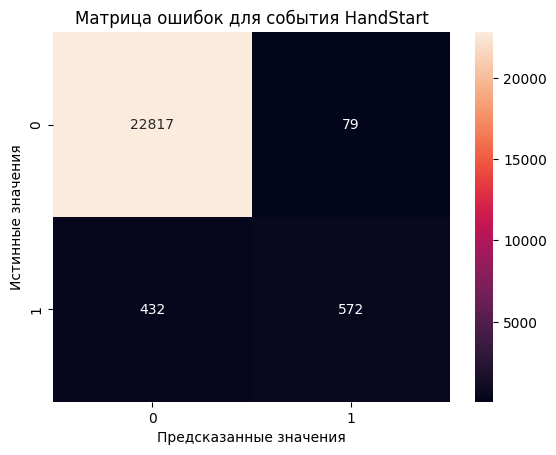

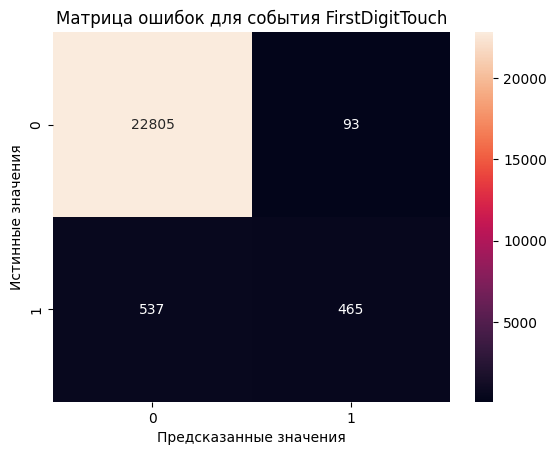

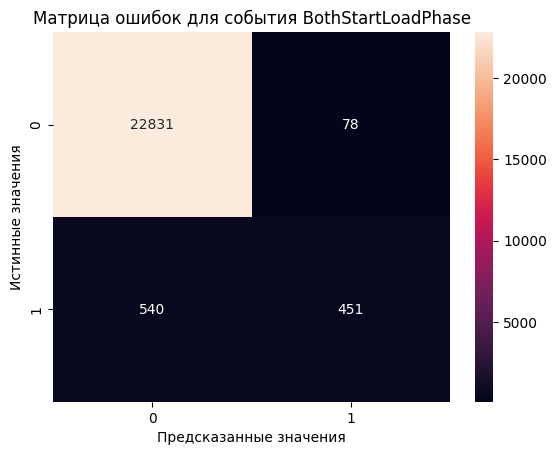

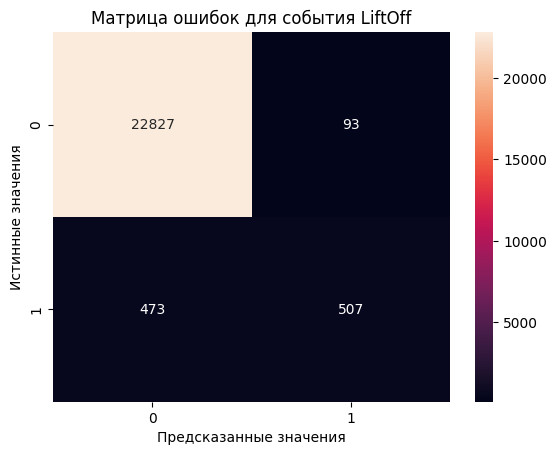

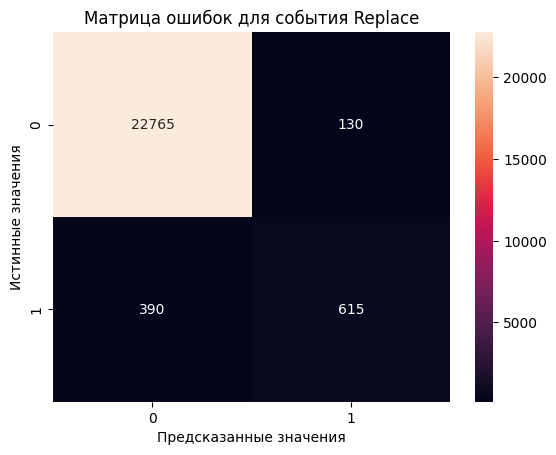

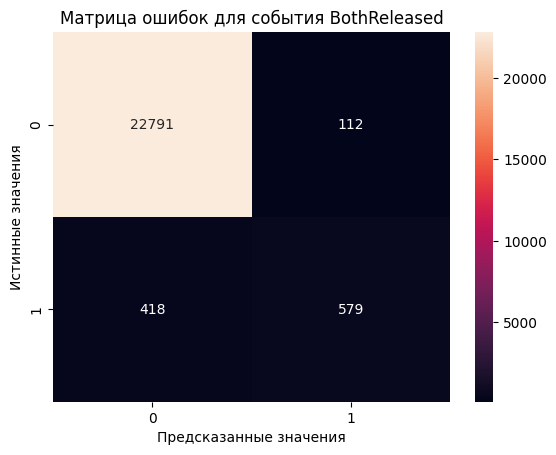

In [ ]:
# Словарь для хранения матриц ошибок
confusion_matrices = {}

# Вычисление предсказаний и матриц ошибок для каждого события
for event in target_events:
    y_pred = models[event].predict(X_val)
    cm = confusion_matrix(y_val[event], y_pred)
    confusion_matrices[event] = cm

    # Визуализация матрицы ошибок
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(f'Матрица ошибок для события {event}')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()


Матрицы ошибок показывают количество верных и неверных предсказаний модели:  

**Истинно положительные (True Positives, TP):** Модель верно предсказала наличие события.  
**Истинно отрицательные (True Negatives, TN):** Модель верно предсказала отсутствие события.  
**Ложно положительные (False Positives, FP):** Модель неверно предсказала наличие события (ошибки первого рода).  
**Ложно отрицательные (False Negatives, FN):** Модель неверно предсказала отсутствие события (ошибки второго рода).  

Для каждого события мы хотим, чтобы количество TP и TN было как можно больше, а количество FP и FN было как можно меньше.

**Матрицы показывают следующее:**

**BothReleased:** модель имеет тенденцию к некоторому количеству ложно отрицательных и ложно положительных результатов, однако большинство предсказаний верны.  
**BothStartLoadPhase:** аналогично, модель демонстрирует хорошую способность к верному предсказанию, но с некоторым количеством FN и FP.  
**FirstDigitTouch:** схожая ситуация с предыдущими, но количество FN и FP немного выше.  
**HandStart:** здесь мы видим, что количество FN и FP также велико, что указывает на пространство для улучшения модели.  
**LiftOff:** модель показывает хорошие результаты, однако, как и в других случаях, присутствует FN и FP.  
**Replace:** обнаруживается значительное количество FN, что может указывать на то, что модель иногда упускает моменты, когда событие происходит.

#Анализ и Рекомендации:
**Улучшение Баланса Классов:** (то есть одно событие происходит гораздо реже других), возможно попробовать методы балансировки классов, такие как взвешивание классов в XGBoost или использование техник пересэмплинга.  

**Оптимизация Гиперпараметров:** Подстройка гиперпараметров модели может помочь уменьшить количество ошибок. Это может включать изменение скорости обучения, глубины деревьев, количества деревьев и так далее.  

**Дополнительные Признаки:** Можно исследовать, как добавление новых признаков или использование других методов извлечения признаков может повлиять на производительность модели.  

**Использование Информации О Времени:** Поскольку ЭЭГ-данные имеют временную природу, использование методов, которые учитывают временные зависимости (например, рекуррентные нейронные сети или LSTM), может улучшить производительность.  

**Проведение Кросс-Валидации:** Чтобы лучше оценить обобщающую способность модели, можно использовать кросс-валидацию с несколькими разбиениями данных.  

Эти шаги могут помочь улучшить точность модели и уменьшить количество ошибок при классификации.